In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from glob import glob 

import pandas as pd

from fastcore.xtras import load_pickle

from gptchem.settings import ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH

import matplotlib.pyplot as plt 
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use(['science', 'nature'])

%matplotlib inline

## Load results

In [3]:
all_out = glob("out/**/*.pkl")

In [4]:
all_out = [load_pickle(p) for p in all_out]

In [5]:
extracted_res = []
xgboost_results = []
tabpfn_results = []

for out in all_out: 
    try:
        res = {
            'train_size': out['train_size'],
            'frac_valid': out['frac_valid'],
            'accuracy': out['accuracy'],
            'f1_macro': out['f1_macro'],
            'f1_micro': out['f1_micro'],
            'kappa': out['kappa'],
            "num_classes": out['num_classes'],
            "representation": out['representation']
        }
        extracted_res.append(res)
    except KeyError:
        pass

    xgb_res = {
        'train_size': out['train_size'], 
        'accuracy': out['xgboost_baseline']['accuracy'], 
        'f1_macro': out['xgboost_baseline']['f1_macro'],
        'f1_micro': out['xgboost_baseline']['f1_micro'],
        'kappa': out['xgboost_baseline']['kappa'],
        "num_classes": out['num_classes']
    }

    tabpfn_res = {
        'train_size': out['train_size'], 
        'accuracy': out['tabpfn_baseline']['accuracy'], 
        'f1_macro': out['tabpfn_baseline']['f1_macro'],
        'f1_micro': out['tabpfn_baseline']['f1_micro'],
        'kappa': out['tabpfn_baseline']['kappa'],
        "num_classes": out['num_classes']
    }

    
    xgboost_results.append(xgb_res)
    tabpfn_results.append(tabpfn_res)

In [6]:
res = pd.DataFrame(extracted_res)
xgboost_res = pd.DataFrame(xgboost_results)
tabpfn_res = pd.DataFrame(tabpfn_results)

In [7]:
grouped_res = res.groupby(['num_classes', "representation", 'train_size']).agg(['mean', 'std'])

In [8]:
grouped_xgboost_res = xgboost_res.groupby(['num_classes', 'train_size']).agg(['mean', 'std'])

In [9]:
grouped_tabpfn_res = tabpfn_res.groupby(['num_classes', 'train_size']).agg(['mean', 'std'])

In [10]:
grouped_res.loc[2,:]

frac_valid     accuracy      f1_macro     f1_micro  \
                                mean std     mean std      mean std     mean   
representation train_size                                                      
inchi          10                1.0 NaN    0.484 NaN  0.474850 NaN    0.484   
               50                1.0 NaN    0.544 NaN  0.543737 NaN    0.544   
iupac_name     10                1.0 NaN    0.500 NaN  0.333333 NaN    0.500   
selfies        10                1.0 NaN    0.524 NaN  0.390506 NaN    0.524   
smiles         10                1.0 NaN    0.520 NaN  0.490662 NaN    0.520   
               50                1.0 NaN    0.564 NaN  0.563154 NaN    0.564   

                                  kappa      
                          std      mean std  
representation train_size                    
inchi          10         NaN -0.034118 NaN  
               50         NaN  0.088408 NaN  
iupac_name     10         NaN -0.007999 NaN  
selfies        10         NaN  0.040879 NaN  
smiles         10         NaN  0.036361 NaN  
               50         NaN  0.128669 NaN

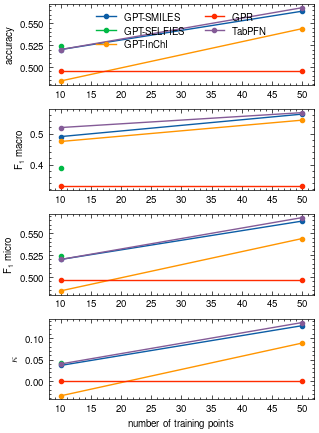

In [13]:
fig, ax = plt.subplots(4, 1, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH))

# plot the binary case, i.e. num_classes = 2

for i, metric in enumerate(['accuracy', 'f1_macro', 'f1_micro', 'kappa']):
    ax[i].plot(
        grouped_res.loc[2, 'smiles', :].index,
        grouped_res.loc[2, 'smiles', :][metric]['mean'],
        marker='o',
        label='GPT-SMILES',
    )
    ax[i].fill_between(
        grouped_res.loc[2, 'smiles', :].index,
        grouped_res.loc[2, 'smiles', :][metric]['mean'] - grouped_res.loc[2, 'smiles', :][metric]['std'],
        grouped_res.loc[2, 'smiles', :][metric]['mean'] + grouped_res.loc[2, 'smiles', :][metric]['std'],
        alpha=0.2,
    )

    ax[i].plot(
        grouped_res.loc[2, 'selfies', :].index,
        grouped_res.loc[2, 'selfies', :][metric]['mean'],
        marker='o',
        label='GPT-SELFIES',
    )
    ax[i].fill_between(
        grouped_res.loc[2, 'selfies', :].index,
        grouped_res.loc[2, 'selfies', :][metric]['mean'] - grouped_res.loc[2, 'selfies', :][metric]['std'],
        grouped_res.loc[2, 'selfies', :][metric]['mean'] + grouped_res.loc[2, 'selfies', :][metric]['std'],
        alpha=0.2,
    )


    ax[i].plot(
        grouped_res.loc[2, 'inchi', :].index,
        grouped_res.loc[2, 'inchi', :][metric]['mean'],
        marker='o',
        label='GPT-InChI',
    )
    ax[i].fill_between(
        grouped_res.loc[2, 'inchi', :].index,
        grouped_res.loc[2, 'inchi', :][metric]['mean'] - grouped_res.loc[2, 'inchi', :][metric]['std'],
        grouped_res.loc[2, 'inchi', :][metric]['mean'] + grouped_res.loc[2, 'inchi', :][metric]['std'],
        alpha=0.2,
    )



    ax[i].plot(
        grouped_xgboost_res.loc[2,:].index,
        grouped_xgboost_res.loc[2,:][metric]['mean'],
        marker='o',
        label='GPR'
    )
    ax[i].fill_between(
        grouped_xgboost_res.loc[2,:].index,
        grouped_xgboost_res.loc[2,:][metric]['mean'] - grouped_xgboost_res.loc[2,:][metric]['std'],
        grouped_xgboost_res.loc[2,:][metric]['mean'] + grouped_xgboost_res.loc[2,:][metric]['std'],
        alpha=0.2,
    )

    ax[i].plot(
        grouped_tabpfn_res.loc[2,:].index,
        grouped_tabpfn_res.loc[2,:][metric]['mean'],
        marker='o',
        label='TabPFN'
    )
    ax[i].fill_between(
        grouped_tabpfn_res.loc[2,:].index,
        grouped_tabpfn_res.loc[2,:][metric]['mean'] - grouped_tabpfn_res.loc[2,:][metric]['std'],
        grouped_tabpfn_res.loc[2,:][metric]['mean'] + grouped_tabpfn_res.loc[2,:][metric]['std'],
        alpha=0.2,
    )

ax[-1].set_xlabel('number of training points')
ax[0].legend(ncols=2)

ax[0].set_ylabel('accuracy')
ax[1].set_ylabel(r'F$_{1}$ macro')
ax[2].set_ylabel(r'F$_{1}$ micro')
ax[3].set_ylabel(r'$\kappa$')

fig.tight_layout()
fig.savefig('lipophilicity-classification_results_binary.pdf', bbox_inches='tight')

KeyError: 5

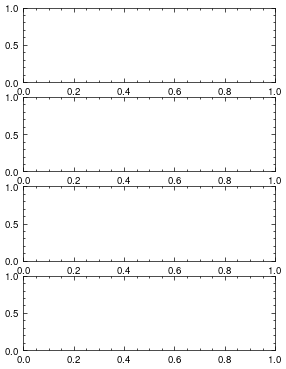

In [14]:
fig, ax = plt.subplots(4, 1, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH))

# plot the binary case, i.e. num_classes = 2

for i, metric in enumerate(['accuracy', 'f1_macro', 'f1_micro', 'kappa']):
    ax[i].plot(
        grouped_res.loc[5, 'smiles', :].index,
        grouped_res.loc[5, 'smiles', :][metric]['mean'],
        marker='o',
        label='GPT-SMILES',
    )
    ax[i].fill_between(
        grouped_res.loc[5, 'smiles', :].index,
        grouped_res.loc[5, 'smiles', :][metric]['mean'] - grouped_res.loc[5, 'smiles', :][metric]['std'],
        grouped_res.loc[5, 'smiles', :][metric]['mean'] + grouped_res.loc[5, 'smiles', :][metric]['std'],
        alpha=0.2,
    )

    ax[i].plot(
        grouped_res.loc[5, 'selfies', :].index,
        grouped_res.loc[5, 'selfies', :][metric]['mean'],
        marker='o',
        label='GPT-SELFIES',
    )
    ax[i].fill_between(
        grouped_res.loc[5, 'selfies', :].index,
        grouped_res.loc[5, 'selfies', :][metric]['mean'] - grouped_res.loc[5, 'selfies', :][metric]['std'],
        grouped_res.loc[5, 'selfies', :][metric]['mean'] + grouped_res.loc[5, 'selfies', :][metric]['std'],
        alpha=0.2,
    )


    ax[i].plot(
        grouped_res.loc[5, 'inchi', :].index,
        grouped_res.loc[5, 'inchi', :][metric]['mean'],
        marker='o',
        label='GPT-InChI',
    )
    ax[i].fill_between(
        grouped_res.loc[5, 'inchi', :].index,
        grouped_res.loc[5, 'inchi', :][metric]['mean'] - grouped_res.loc[5, 'inchi', :][metric]['std'],
        grouped_res.loc[5, 'inchi', :][metric]['mean'] + grouped_res.loc[5, 'inchi', :][metric]['std'],
        alpha=0.2,
    )

    ax[i].plot(
        grouped_res.loc[5, 'name', :].index,
        grouped_res.loc[5, 'name', :][metric]['mean'],
        marker='o',
        label='GPT-Name',
    )
    ax[i].fill_between(
        grouped_res.loc[5, 'name', :].index,
        grouped_res.loc[5, 'name', :][metric]['mean'] - grouped_res.loc[5, 'name', :][metric]['std'],
        grouped_res.loc[5, 'name', :][metric]['mean'] + grouped_res.loc[5, 'name', :][metric]['std'],
        alpha=0.2,
    )
    
    ax[i].plot(
        grouped_xgboost_res.loc[5,:].index,
        grouped_xgboost_res.loc[5,:][metric]['mean'],
        marker='o',
        label='GPR'
    )
    ax[i].fill_between(
        grouped_xgboost_res.loc[5,:].index,
        grouped_xgboost_res.loc[5,:][metric]['mean'] - grouped_xgboost_res.loc[5,:][metric]['std'],
        grouped_xgboost_res.loc[5,:][metric]['mean'] + grouped_xgboost_res.loc[5,:][metric]['std'],
        alpha=0.2,
    )

    ax[i].plot(
        grouped_tabpfn_res.loc[5,:].index,
        grouped_tabpfn_res.loc[5,:][metric]['mean'],
        marker='o',
        label='TabPFN'
    )
    ax[i].fill_between(
        grouped_tabpfn_res.loc[5,:].index,
        grouped_tabpfn_res.loc[5,:][metric]['mean'] - grouped_tabpfn_res.loc[5,:][metric]['std'],
        grouped_tabpfn_res.loc[5,:][metric]['mean'] + grouped_tabpfn_res.loc[5,:][metric]['std'],
        alpha=0.2,
    )

ax[-1].set_xlabel('training size')
ax[0].legend(ncols=2, columnspacing=.5)

ax[0].set_ylabel('accuracy')
ax[1].set_ylabel(r'F$_{1}$ macro')
ax[2].set_ylabel(r'F$_{1}$ micro')
ax[3].set_ylabel(r'$\kappa$')

fig.tight_layout()
fig.savefig('lipophilicity-classification_results_5_class.pdf', bbox_inches='tight')